In [1]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
detail = 1000
T = np.linspace(0, 1, detail) # Only needed when drawing the function!!!

In [3]:
indicator = lambda t, l, u: 1 if ((t==u==1)|((t>=l)&(t<u))) else 0 # This complicated expression is needed to ensure no bugs in the output.
def step(t, w):
       internal_knots = len(w)-1
       increment = 1/(internal_knots+1) # w=[0, 1, -1] -> increment = 1/(2+1)=0.33 -> [0, 0.33, 0.66, 1]
       lower = [increment*i for i in range(internal_knots+1)]
       upper = [increment*(i+1) for i in range(internal_knots+1)]
       p=0
       for i in range(len(w)):
              p += indicator(t, l=lower[i], u=upper[i])*w[i]
       return p

polynomial = lambda t, p=0: t**p

In [4]:
def plot_basis(T, w, f):

       fig, ax = plt.subplots()
       ax.plot(T, [f(t, w=w) for t in T], zorder=-1)

       # Calculate knots and weights
       knots = [(1/(len(w)-1+1))*(i+1) for i in range(len(w)-1+1-1)] # for easier calculations see the step function calculations
       weights = [w[i+1] for i in range(len(w)-1)] # we want to exclude the first and last points, as these will be drawn with a different colour

       # Draw knots
       ax.scatter(knots, weights , color="darkorange", s=75, zorder=1) # internal knots
       ax.scatter([0, 1], [w[0], w[len(w)-1]], color="black", s=75, zorder=1) # support knots
       ax.set_xlabel("$t$")
       ax.set_ylabel("$f(t)$")
       ax.grid(visible=False)
       plt.show()

In [5]:
gen_rand_design = lambda runs, feats: np.random.rand(runs, feats)

In [8]:
runs = 10
feats = 5
Gamma = gen_rand_design(runs, feats)
levels = [-1, 0, 1]
for run in range(runs):
       for feat in range(feats):
              best_level_list = []
              for level in levels:
                     Gamma[run, feat] = levels[level]
                     M = Gamma.T @ Gamma
                     criterion = np.trace(M)
                     best_level_list.append(criterion)
              best_level = best_level_list.index(max(best_level_list))
              Gamma[run, feat] = levels[best_level]
Gamma

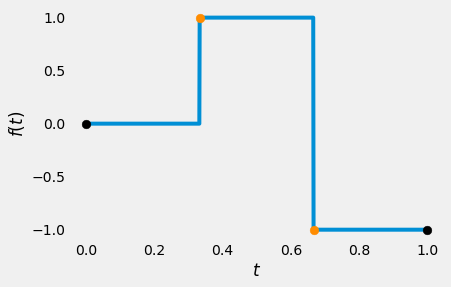

In [60]:
plot_basis(T=T, w=[0,1,-1], f=step)

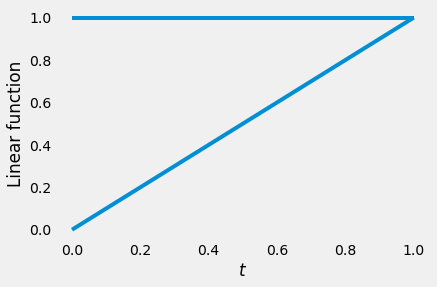

In [61]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Linear function")
ax.grid(visible=False)
plt.show()

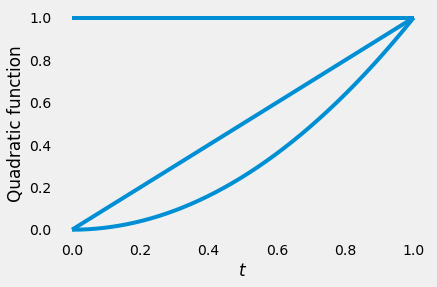

In [62]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=2) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Quadratic function")
ax.grid(visible=False)
plt.show()

In [63]:
quad(step, 0, 1, args=([1,1,1]))

(1.0, 1.1102230246251565e-14)

In [64]:
quad(lambda t: (step(t, w=[0,1,-1]))*(polynomial(t, p=0) + polynomial(t, p=1)), 0, 1)[0]

-0.11111111111111115

In [96]:
w = [1, 1, 1]
# m_11 = quad(lambda t: (indicator(t,l=0, u=1/3)*w[0])*(polynomial(t, p=0)), 0,1)[0]
# m_12 = quad(lambda t: (indicator(t,l=0, u=1/3)*w[0])*(polynomial(t, p=1)), 0,1)[0]
#
# m_21 = quad(lambda t: (indicator(t,l=1/3, u=2/3)*w[1])*(polynomial(t, p=0)), 0,1)[0]
# m_22 = quad(lambda t: (indicator(t,l=1/3, u=2/3)*w[1])*(polynomial(t, p=1)), 0,1)[0]
#
# m_31 = quad(lambda t: (indicator(t,l=2/3, u=1)*w[2])*(polynomial(t, p=0)), 0,1)[0]
# m_32 = quad(lambda t: (indicator(t,l=2/3, u=1)*w[2])*(polynomial(t, p=1)), 0,1)[0]

In [101]:
J_cb = np.array([
       [quad(lambda t: (indicator(t,l=0, u=1/3)*w[0])*(polynomial(t, p=0)), 0,1)[0], quad(lambda t: (indicator(t,l=0, u=1/3)*w[0])*(polynomial(t, p=1)), 0,1)[0]],
       [quad(lambda t: (indicator(t,l=1/3, u=2/3)*w[1])*(polynomial(t, p=0)), 0,1)[0], quad(lambda t: (indicator(t,l=1/3, u=2/3)*w[1])*(polynomial(t, p=1)), 0,1)[0]],
       [quad(lambda t: (indicator(t,l=2/3, u=1)*w[2])*(polynomial(t, p=0)), 0,1)[0], quad(lambda t: (indicator(t,l=2/3, u=1)*w[2])*(polynomial(t, p=1)), 0,1)[0]]
])
J_cb

array([[0.33333333, 0.05555556],
       [0.33333333, 0.16666667],
       [0.33333333, 0.27777778]])

In [102]:
Gamma = np.random.rand(4,3)

In [103]:
np.linalg.det(J_cb.T @ Gamma.T @ Gamma @ J_cb)

0.014000530280179793